#1. Data

In [ ]:
prin

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL # Python Image Library
import pathlib 

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True) # store data received from url in the flower_photos directory
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


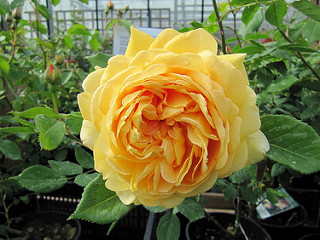

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

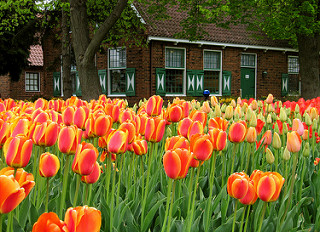

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

#2. Dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 5
epochs = 10

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
print(train_dataset.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
print(validation_dataset.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
class_names = train_dataset.class_names

#3. Visualization

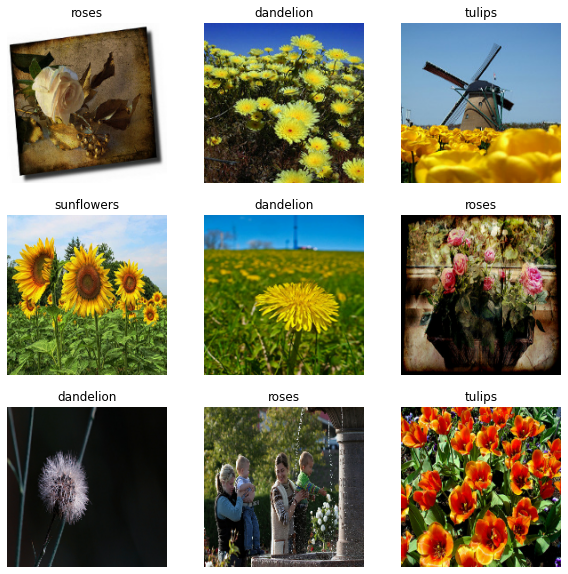

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # make buffer size dynamic when moving data from hard disk to cache memory
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_dataset = train_dataset.map(lambda x,y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# notice the pixels values are now in '[0,1]'
print(np.min(first_image), np.max(first_image))

0.008872573 0.7322078


#4. Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 35s 36ms/step - loss: 1.2931 - accuracy: 0.4588 - val_loss: 1.0325 - val_accuracy: 0.5736
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9595 - accuracy: 0.6328 - val_loss: 0.9550 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.7594 - accuracy: 0.7061 - val_loss: 0.9250 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.5330 - accuracy: 0.8079 - val_loss: 1.0196 - val_accuracy: 0.6322
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.3541 - accuracy: 0.8774 - val_loss: 1.0552 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.2017 - accuracy: 0.9353 - val_loss: 1.1729 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1352 - accuracy: 0.9567 - val_loss: 1.4424 - val_accuracy: 0.6117
Epoch 8/10
9

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

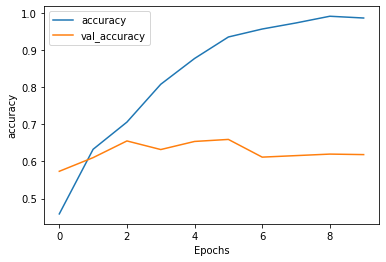

In [ ]:
plot_graphs(history, 'accuracy')

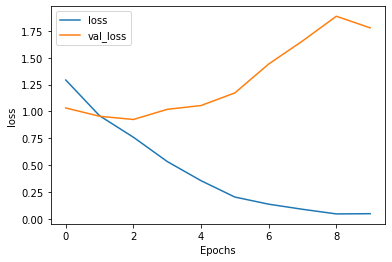

In [ ]:
plot_graphs(history, 'loss')

#5. Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                           input_shape = (img_height,img_width,3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

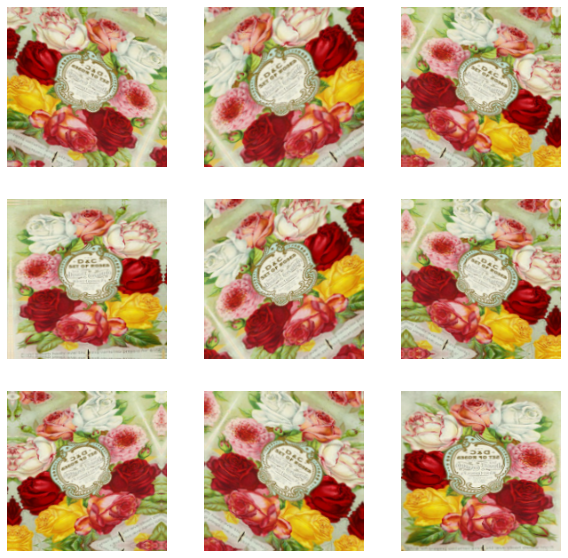

In [ ]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 5s 49ms/step - loss: 1.3116 - accuracy: 0.4404 - val_loss: 1.0767 - val_accuracy: 0.5899
Epoch 2/10
92/92 [==============================] - 4s 46ms/step - loss: 1.0052 - accuracy: 0.6134 - val_loss: 1.0652 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 4s 46ms/step - loss: 0.9344 - accuracy: 0.6393 - val_loss: 1.0511 - val_accuracy: 0.5940
Epoch 4/10
92/92 [==============================] - 4s 46ms/step - loss: 0.8862 - accuracy: 0.6587 - val_loss: 0.8464 - val_accuracy: 0.6894
Epoch 5/10
92/92 [==============================] - 4s 46ms/step - loss: 0.8276 - accuracy: 0.6849 - val_loss: 0.7911 - val_accuracy: 0.7044
Epoch 6/10
92/92 [==============================] - 4s 46ms/step - loss: 0.7804 - accuracy: 0.7037 - val_loss: 0.7665 - val_accuracy: 0.7125
Epoch 7/10
92/92 [==============================] - 4s 46ms/step - loss: 0.7519 - accuracy: 0.7207 - val_loss: 0.7493 - val_accuracy: 0.7125
Epoch 8/10
92

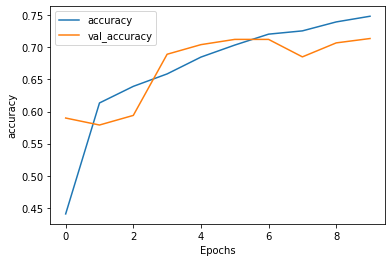

In [ ]:
plot_graphs(history, 'accuracy')

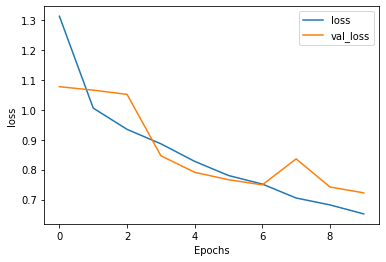

In [ ]:
plot_graphs(history, 'loss')